Let's continue the previous work by generating the phenotype matrices for a number of different tools. After we decide on the best tool, we can play with p-values and other phenotypes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
# figure out who is who in each trio
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']
trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if fa[:4] in wes_prefix and mo[:4] in wes_prefix and sid[:4] in wes_prefix:
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)

fid = open('/data/sudregp/cnv/kid_samples.txt', 'r')
good_kids = [line.rstrip() for line in fid]
fid.close()

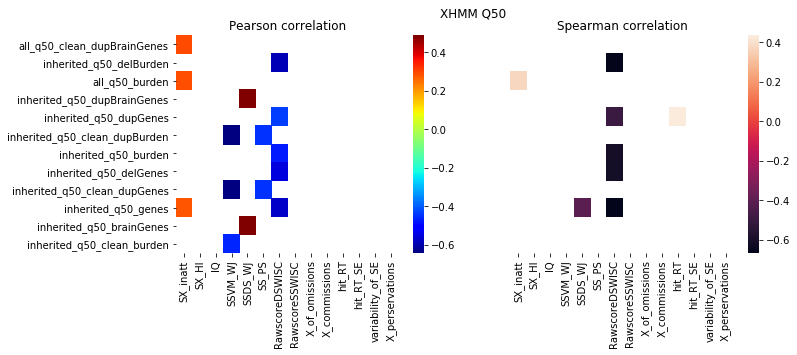

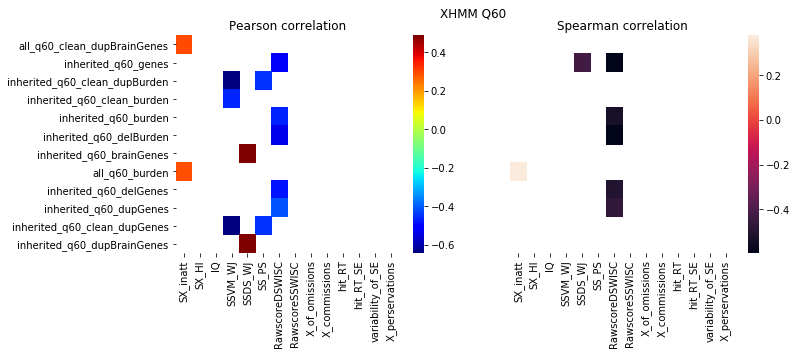

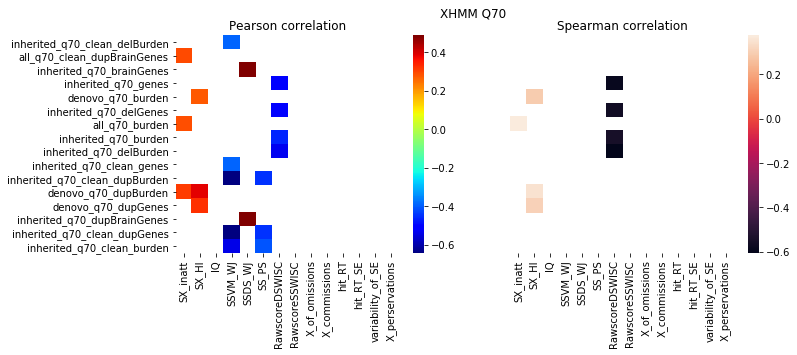

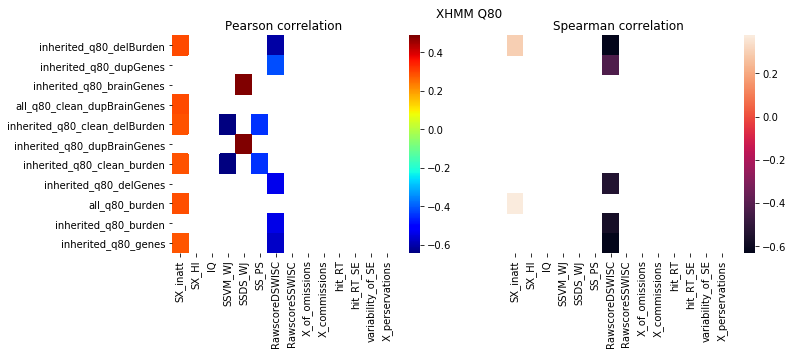

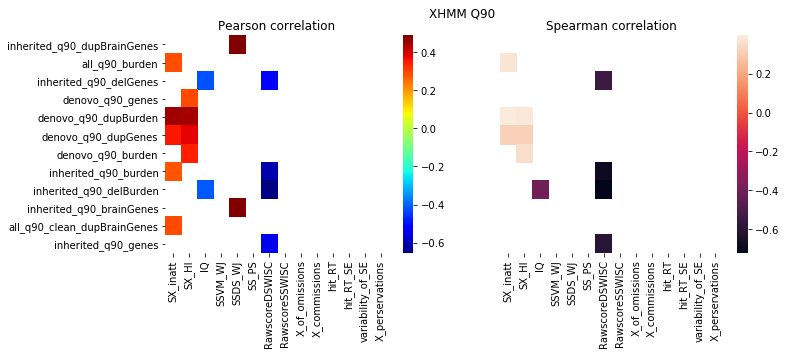

In [41]:
from scipy import stats


fname1 = '/home/sudregp/data/cnv/sx_simplex.csv'
pheno1 = pd.read_csv(fname1).drop(['Unnamed: 0', 'Date'], axis=1)
fname2 = '/home/sudregp/data/cnv/neuropsych_09062017.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/cnv/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    pcorrs = []
    scorrs = []
    titles = []
    for f in files:
        # open PLINK file and grab the burden for all kids
        df = pd.read_table(f, delimiter='\s+', index_col=1)
        kids = [t['child'] for t in trios]
        ncnv = []
        for kid in kids:
            idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
            ncnv.append(int(df.iloc[idx]['NSEG']))
        df3 = pd.DataFrame(ncnv, index=kids, columns=['ncnv'])
        data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
        data = pd.merge(data, df3, left_on='code', right_index=True)
        # panda's corr() doesn't give p-vals, so let's do an ugly loop
        ps, ss = [], []
        x = 'ncnv'
        p_thresh = .05
        y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', x]]
        for y in y_cols:
            tmp_df = data[[x, y]].dropna()
            r, p = stats.pearsonr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            if p > p_thresh:
                r = np.nan
            ps.append(r)
            r, p = stats.spearmanr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            if p > p_thresh:
                r = np.nan
            ss.append(r)
        # save the result if it's not NaN all across the board
        if not np.isnan(ps).all():
            pcorrs.append(ps)
            scorrs.append(ss)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            titles.append(t_str)
    plt.figure(figsize=(11,4))
    plt.subplot(1,2,1)
    sns.heatmap(pd.DataFrame(pcorrs, index=titles, columns=y_cols), cmap='jet')
    plt.title('Pearson correlation')
    plt.subplot(1,2,2)
    sns.heatmap(pd.DataFrame(scorrs, index=titles, columns=y_cols), yticklabels=False)
    plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d' % q)

Let's put that into a function:

In [48]:
def compute_correlations(files, p_thresh=.05, x='ncnv'):
    pcorrs = []
    scorrs = []
    ptitles, stitles = [], []
    for f in files:
        # open PLINK file and grab the burden for all kids
        df = pd.read_table(f, delimiter='\s+', index_col=1)
        kids = [t['child'] for t in trios]
        ncnv = []
        for kid in kids:
            idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
            ncnv.append(int(df.iloc[idx]['NSEG']))
        df3 = pd.DataFrame(ncnv, index=kids, columns=[x])
        data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
        data = pd.merge(data, df3, left_on='code', right_index=True)
        # panda's corr() doesn't give p-vals, so let's do an ugly loop
        ps, ss = [], []
        y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', x]]
        for y in y_cols:
            tmp_df = data[[x, y]].dropna()
            r, p = stats.pearsonr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            if p > p_thresh:
                r = np.nan
            ps.append(r)
            r, p = stats.spearmanr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            if p > p_thresh:
                r = np.nan
            ss.append(r)
        # save the result if it's not NaN all across the board
        if not np.isnan(ps).all():
            pcorrs.append(ps)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            ptitles.append(t_str)
        if not np.isnan(ss).all():
            scorrs.append(ss)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            stitles.append(t_str)
            
    return (pd.DataFrame(pcorrs, index=ptitles, columns=y_cols),
            pd.DataFrame(scorrs, index=stitles, columns=y_cols))

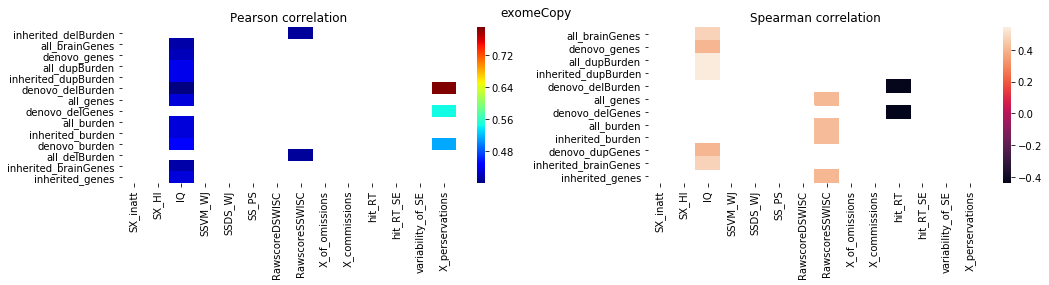

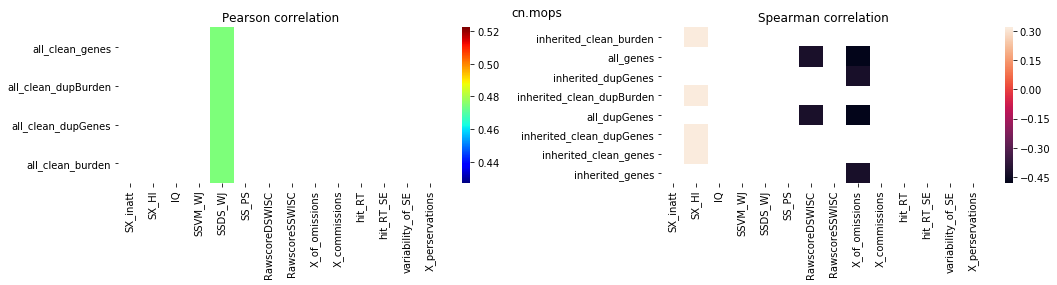

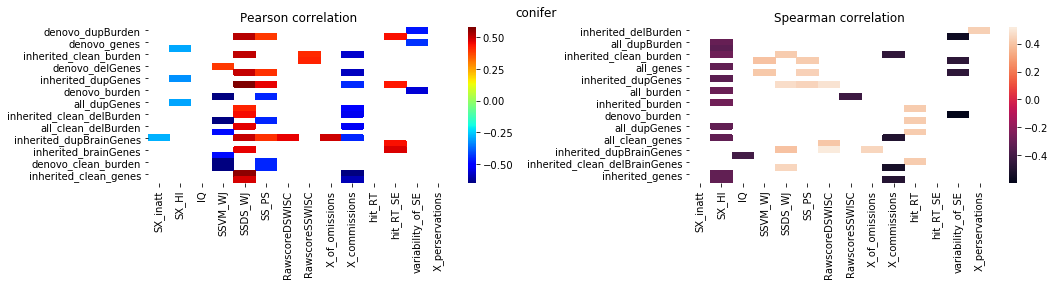

In [55]:
fname1 = '/home/sudregp/data/cnv/sx_simplex.csv'
pheno1 = pd.read_csv(fname1).drop(['Unnamed: 0', 'Date'], axis=1)
fname2 = '/home/sudregp/data/cnv/neuropsych_09062017.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/cnv/nisc_to_mrn.txt')

for tool in ['exomeCopy', 'cn.mops', 'conifer']:
    data_dir = '/home/sudregp/data/cnv/%s/' % tool
    files = glob.glob(data_dir + '/*cnv.indiv')
    pcorrs, scorrs = compute_correlations(files)
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    sns.heatmap(pcorrs, cmap='jet')
    plt.title('Pearson correlation')
    plt.subplot(1,2,2)
    sns.heatmap(scorrs)
    plt.title('Spearman correlation')
    plt.suptitle('%s' % tool)
    plt.tight_layout()

Let's re-plot the different XHMM quality settings with this new modular code:

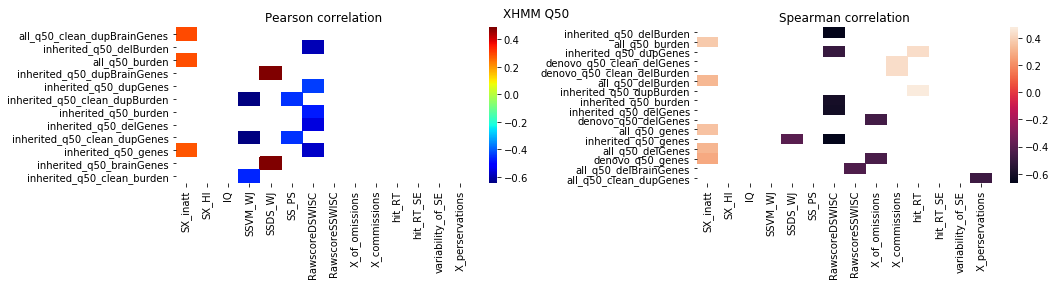

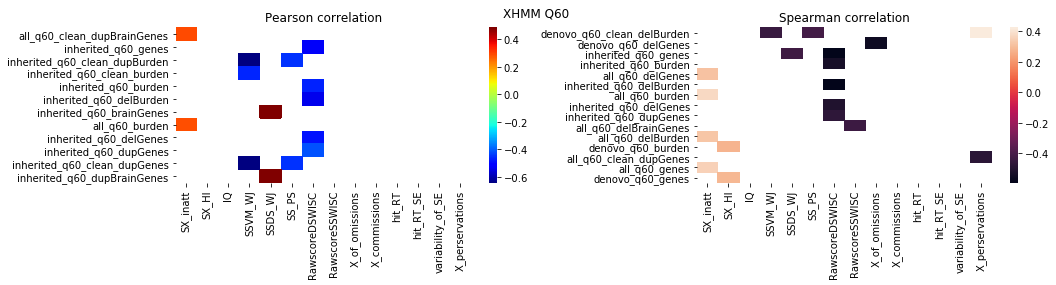

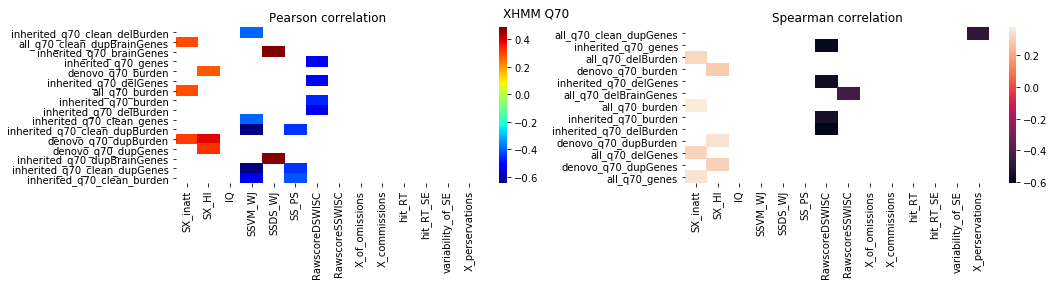

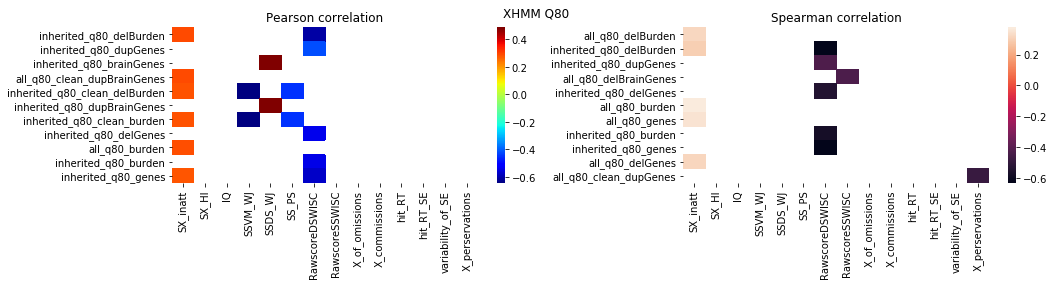

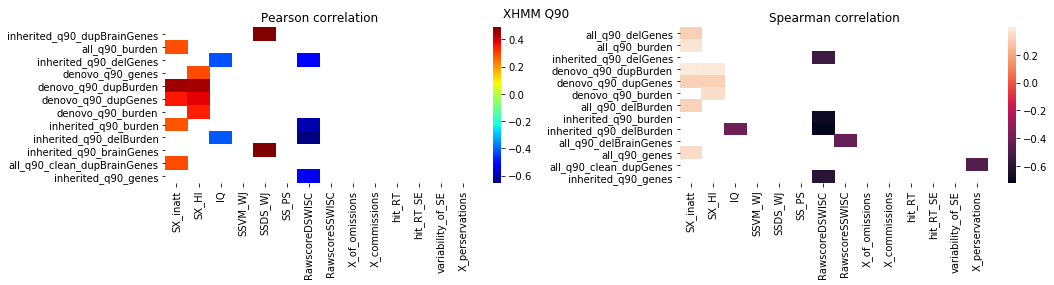

In [57]:
from scipy import stats


fname1 = '/home/sudregp/data/cnv/sx_simplex.csv'
pheno1 = pd.read_csv(fname1).drop(['Unnamed: 0', 'Date'], axis=1)
fname2 = '/home/sudregp/data/cnv/neuropsych_09062017.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/cnv/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    pcorrs, scorrs = compute_correlations(files)
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    sns.heatmap(pcorrs, cmap='jet')
    plt.title('Pearson correlation')
    plt.subplot(1,2,2)
    sns.heatmap(scorrs)
    plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d' % q)
    plt.tight_layout()
    plt.show()

Just keep in mind that the neuropsych file being used is not complete. For now I just want to get a better sense for what tool/QC to use. But it makes more sense to make the neuropsych file more complete only when we gather the neuropsych for the multiplex samples as well. Also, exomeCopy had too many variants, so I had not calculated it before. I'm doing it now, while I refine our neuropsych file.

# TODO
 * add multiplex and make better phenotype file 
 * use correlations of the differences, to preserve familial relationships. For example, correlate the ncnv differences within siblings with the phenotypical differences within siblings
 * try different similarity metrics (could use one of the many nonlinear methods in sklearn, but then would need to derive p-values through permutation!)
 * play with each tool parameters to see if we can get better results